In [12]:
import pickle
a = open("Articles.pickle",'rb')
uncleanedarticles = pickle.load(a)
articles=[]
text=""
title=""
titles=[]
sources=[]
for i in uncleanedarticles:
    source,url,title,text = i[0],i[1],i[2],i[3]
    sources.append(source)
    text = text.replace('\n\n','\n')
    if text =="":
        continue
    if text.count('\n') <10:
        continue
    if text.count('https://') >10:
        continue   
    title = title.strip(' ')
    if title in titles:
        continue
    titles.append(title)
    articles.append([source,url,title,text])
a.close()

In [2]:
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
ps = SnowballStemmer('english')
wordRepArticles =[]
idf={}

articleslen=[]
for i in articles:
    title,text = i[2],i[3]
    text = text.replace('\\','');text = text.replace('.\n','\n');text = text.replace('\n\n','\n')
    articledist={}
    sentencelis=[]
    count=0
    for i in (text+'\n'+title).split('\n'):
        if i ==title:
            mult =2
        else:
            mult =1
        linedist={}
        v = i.split(' ')
        if len(v)<4:
            continue
        for word in v:
            if word not in stopwords.words('english'):
                word = word.replace('(','');word = word.replace(')','')
                word = word.replace('"','');word = word.replace(',','');word = word.strip(' ')
                stemmed = ps.stem(word)
                if stemmed in articledist.keys():
                    articledist[stemmed]+=mult
                else:
                    articledist[stemmed]=mult
                if stemmed in linedist.keys():
                    linedist[stemmed]+=1
                else:
                    linedist[stemmed]=1
            count+=1
        sentencelis.append([i,linedist])
    for words in articledist.keys():   
        if words in idf.keys():
            idf[words]+=1
        else:
            idf[words]=1
    wordRepArticles.append([title,articledist,sentencelis])
    articleslen.append(count)

In [3]:
# print(len(wordRepArticles))
# print(wordRepArticles[0])
print(len(articles))
print(len(uncleanedarticles))

2352
6198


In [4]:
articles[:3]

[['abcnews',
  'https://abcnews.go.com/US/reads-monday/story?id=59712958',
  'Must reads before Monday',
  'One parent\'s decision to shame his daughter on social media drew mixed responses, Florida is struggling with major toxic algae blooms, the only operating spaceport in the world is crumbling, and eight children affected by Trump\'s "zero-tolerance" border policy are still waiting to be reunited with their families.\nDon’t miss out on some of ABC News\' best reporting from this week.\n\'What are you trying to prove?\': Parenting experts weigh in on dad\'s bullying punishment\nSTOCK/Getty Images\nA viral video posted by a father that forced his daughter to walk 5 miles to school in near-freezing temperatures has prompted questions about the use of social media as a way to humiliate and discipline children. Some experts say that shame is not an "effective way to change behavior."\n\'When is this going to stop?\': Florida activist highlights devastating impact of algae blooms on wild

In [5]:
import math
n = len(articles)
avgArticleLen = sum(articleslen)*1.0/n
match = [[0 for i in range(n)] for i in range(n)]
for i in range(n):
    mainarticle = wordRepArticles[i]
    mainlength = articleslen[i]
    for j in range(i+1,n):
        comparearticle = wordRepArticles[j]
        comparelength = articleslen[j]
        commonwords = list(set(mainarticle[1].keys()) & set(comparearticle[1].keys())) 
        value = 0
        for word in commonwords:
            mainvalue = (1+math.log(mainarticle[1][word]))*1.0/(math.log(1+mainlength/avgArticleLen))
            compvalue = (1+math.log(comparearticle[1][word]))*1.0/(math.log(1+comparelength/avgArticleLen))
            value += mainvalue*compvalue* math.log(1+n/idf[word])
        match[i][j] = value
        match[j][i] = value

In [6]:
topmatches = [[] for i in range(n)]
matches = 3
for i in range(n):
    vals = [[match[i][j],j] for j in range(n)]
    toparticle = sorted(vals,reverse=True)[:matches]
    if i<50:
        print("Main title: "+ articles[i][2])
    for j in range(matches):
        if toparticle[j][0] > 1000:
            topmatches[i].append(toparticle[j])
            if i<50:
                print(str(j)+"/" + str(matches)+ ": " + articles[toparticle[j][1]][2])
matchvalues =[]
for i in topmatches:
    for j in i:
        matchvalues.append(j[0])        

Main title: Must reads before Monday
0/3: Father denied visa for slain daughter's funeral as suspect charged with rape, murder
1/3: Man accused of killing 13-year-old Hania Aguilar could face death penalty if convicted
2/3: FBI: Man arrested in death of North Carolina teenager
Main title: Worcester firefighter dies while battling huge blaze, the latest in a string of firefighter deaths in city
0/3: Chief identifies firefighter who died after becoming trapped in five-alarm Worcester fire
1/3: 5 children under age of 10 die in Ohio house fire
2/3: California marks 1 month since deadly wildfires ripped through state
Main title: Funeral for 'Baby Jane Doe' found near California highway
0/3: Parents charged in 10-month-old daughter's overdose death
1/3: Texas Daycare Worker Accused of Breaking Baby’s Bones
2/3: Boyfriend allegedly kills girlfriend and her 17-year-old daughter: Sheriff
Main title: Amazon touted as big win for NY, but math is more complex
Main title: Qatar emir skips Saudi-ho

Main title: Paris protests continue for third weekend despite Macron conceding to original demands
0/3: Trump: Paris Climate Accord ‘Isn’t Working Out So Well For Paris’ As Riots Engulf City
1/3: Trump on France Chaos: 'End Paris Agreement, Return Money to People'
2/3: Who are France's 'Yellow Jacket' protesters and what do they want?
Main title: Russia's crumbling Baikonur spaceport is Earth's only launch pad for manned flights
0/3: Weeks after scary mishap, Soyuz rocket to launch spaceflyers to space station
1/3: Must reads before Monday
2/3: Astronaut Nick Hague is 'ready to go' again after failed launch to space station
Main title: What does Martian wind sound like? Now we know
0/3: NASA's InSight lander captures first 'sounds' of wind on Mars
1/3: In space first, China launches lunar rover to far side of the moon
2/3: Meet the engineer behind NASA's robotic arm for Mars
Main title: Astronaut Nick Hague is 'ready to go' again after failed launch to space station
0/3: Weeks after sc

In [7]:
print(avgArticleLen)

972.2436224489796


In [8]:
sentmatch = []
for i in range(n):
    mainarticle = wordRepArticles[i]
    rep=[]
    for j in range(len(topmatches[i])):
        comparearticle = wordRepArticles[topmatches[i][j][1]]
        bestmatchSentence =[]
        for k in range(len(mainarticle[2])):
            val = -1
            ind = 0
            msentence = mainarticle[2][k][1]
            mainlength = len(mainarticle[2][k][0].split(' '))
            for l in range(len(comparearticle[2])):
                csentence = comparearticle[2][l][1]
                comparelength = len(comparearticle[2][l][0].split(' '))
                commonwords = list(set(msentence.keys()) & set(csentence.keys())) 
                if len(words)>3:
                    value = 0
                    for word in commonwords:
                        mainvalue = (1+math.log(msentence[word]))*1.0/(math.log(1+mainlength/avgArticleLen))
                        compvalue = (1+math.log(csentence[word]))*1.0/(math.log(1+comparelength/avgArticleLen))
                        value += mainvalue*compvalue* math.log(1+n/idf[word])
                    if value>val:
                        val = value
                        ind = l
            bestmatchSentence.append([ind,val,comparearticle[2][ind][0]])
        rep.append(bestmatchSentence)
    sentmatch.append(rep)

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer() 

sources = list(set(sources))

reliability = [9.9 for i in range(len(sources))]
articleaggreeement=[]
for i in range(n):
    articleval =0
    mainarticle = wordRepArticles[i]
    actualarticlecount=len(topmatches[i])
    for j in range(len(topmatches[i])):
        val=0
        sentcount =0 
        comparticle=wordRepArticles[topmatches[i][j][1]]
        for k in range(len(mainarticle[2])):
            sent1 = analyzer.polarity_scores(mainarticle[2][k][0])['compound']
            if sentmatch[i][j][k][1]==-1:
                continue
            sent2 = analyzer.polarity_scores(sentmatch[i][j][k][2])['compound']
            if (sent1 >0.05 and sent2 >0.05) or (sent1 <-0.05 and sent2 <-0.05) or (sent1 <0.05 and sent2 <0.05 and sent1 >-0.05 and sent2 >-0.05):
                val +=1
            sentcount+=1
        if sentcount > 0.5*len(mainarticle[2]):
            val /= len(mainarticle[2])
            topmatches[i][j][0] = val*100
            articleval +=val*reliability[sources.index(articles[topmatches[i][j][1]][0])]
        else:
            actualarticlecount-=1
    if actualarticlecount==0 :
        articleaggreeement.append(0)
        articles[i].append(0)
    else:
        articleaggreeement.append(articleval/actualarticlecount)
        articles[i].append(articleval/actualarticlecount)

for i in range(n):
    articles[i][0] = sources.index(articles[i][0])
    articles[i].append(i)

In [14]:
print(articles[:2])
print(topmatches[:2])

[[7, 'https://abcnews.go.com/US/reads-monday/story?id=59712958', 'Must reads before Monday', 'One parent\'s decision to shame his daughter on social media drew mixed responses, Florida is struggling with major toxic algae blooms, the only operating spaceport in the world is crumbling, and eight children affected by Trump\'s "zero-tolerance" border policy are still waiting to be reunited with their families.\nDon’t miss out on some of ABC News\' best reporting from this week.\n\'What are you trying to prove?\': Parenting experts weigh in on dad\'s bullying punishment\nSTOCK/Getty Images\nA viral video posted by a father that forced his daughter to walk 5 miles to school in near-freezing temperatures has prompted questions about the use of social media as a way to humiliate and discipline children. Some experts say that shame is not an "effective way to change behavior."\n\'When is this going to stop?\': Florida activist highlights devastating impact of algae blooms on wildlife\nJoe Raed

In [15]:
sourcerelia=[]
for i in range(len(sources)):
    sourcerelia.append([i,sources[i],reliability[i]])
fileObject = open('./mysite/sourcereliability.pickle','wb')
pickle.dump(sourcerelia,fileObject)
fileObject.close()
print(sourcerelia[0])

[0, 'cbsnews', 9.9]


In [16]:
articlesimilarity=[]
for i in range(n):
    for j in range(len(topmatches[i])):
#         articlesimilarity.append([articles[i][2],articles[topmatches[i][j][1]][2]])
        articlesimilarity.append([i,topmatches[i][j][1],topmatches[i][j][0]])
fileObject = open('./mysite/articlessimilarity.pickle','wb')
pickle.dump(articlesimilarity,fileObject)
fileObject.close()

In [17]:
print(articlesimilarity[0])

[0, 400, 64.28571428571429]


In [18]:
fileObject = open('./mysite/cleanedarticles.pickle','wb')
pickle.dump(articles,fileObject)
fileObject.close()

In [19]:
# max([i[0] for i in articles])

In [20]:
matchvalues =[]
for i in topmatches:
    for j in i:
        matchvalues.append(j[0])

100.0 0.0
0 7056


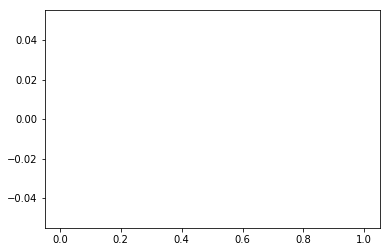

In [22]:
n = len(articles)
import numpy as np
import matplotlib.pyplot as plt
print(max(matchvalues),min(matchvalues))
# cleanval = list(filter(lambda a: a > 1000, matchvalues))
print(len(cleanval),n*3)
_, bins, patches = plt.hist(matchvalues, 10, facecolor='g')
plt.show()

In [24]:
print(matchvalues)

[64.28571428571429, 50.0, 35.714285714285715, 76.47058823529412, 64.70588235294117, 76.47058823529412, 28.57142857142857, 42.857142857142854, 35.714285714285715, 55.00000000000001, 15.0, 20.0, 20.0, 46.666666666666664, 53.333333333333336, 60.71428571428571, 57.14285714285714, 42.857142857142854, 64.70588235294117, 41.17647058823529, 29.411764705882355, 50.0, 55.55555555555556, 16.666666666666664, 96.0, 84.0, 48.0, 50.0, 50.0, 58.333333333333336, 47.05882352941176, 41.17647058823529, 35.294117647058826, 41.66666666666667, 50.0, 58.333333333333336, 85.71428571428571, 21.428571428571427, 14.285714285714285, 90.9090909090909, 90.9090909090909, 90.9090909090909, 46.666666666666664, 40.0, 53.333333333333336, 13.043478260869565, 21.73913043478261, 50.0, 18.181818181818183, 40.909090909090914, 54.54545454545454, 27.27272727272727, 27.27272727272727, 52.17391304347826, 34.78260869565217, 47.82608695652174, 22.727272727272727, 50.0, 45.45454545454545, 60.0, 36.0, 48.0, 68.75, 43.75, 62.5, 57.894